In [3]:
import sys
import os
# ROOT_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
ROOT_DIR=r'C:\Users\logan\Desktop\MEng\Mask_RCNN'
sys.path.append(ROOT_DIR)


import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math

# load the class label names from disk, one label per line
# CLASS_NAMES = open("coco_labels.txt").read().strip().split("\n")

# ROOT_DIR=os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
CLASS_NAMES = ['BG', 'Ice','Ship']
TestDir="\\IceData\\test_imgs\\"
# TestDir="\\IceData\\stage1_save\\"
TrainedWeights=ROOT_DIR+"\\mask_rcnn_iceshiptf1config_0050.h5"

class SimpleConfig(mrcnn.config.Config):
    # Give the configuration a recognizable name
    NAME = "Ice_ship_interference"
    
    # set the number of GPUs to use along with the number of images per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

	# Number of classes = number of classes + 1 (+1 for the background). The background class is named BG
    NUM_CLASSES = len(CLASS_NAMES)

# Initialize the Mask R-CNN model for inference and then load the weights.
# This step builds the Keras model architecture.
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

# Load the weights into the model.
model.load_weights(filepath=TrainedWeights, 
                   by_name=True)

# load the input image, convert it from BGR to RGB channel
Test_Dir=os.listdir(ROOT_DIR+ TestDir) #lists the kangaroo test image dir
randomImg=Test_Dir[random.randint(0,len(Test_Dir)-1)]
image = cv2.imread(ROOT_DIR+TestDir+randomImg) #picks a random image in the kangaroo test image dir.
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform a forward pass of the network to obtain the results
r = model.detect([image], verbose=0)

# Get the results for the first image.
r = r[0]

# Visualize the detected objects.
# print('Chosen random file to display with mask predictions: ',randomImg)

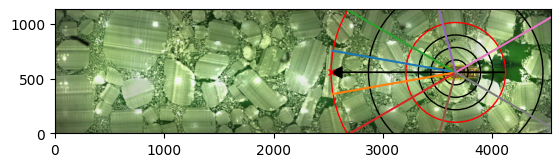

Crossing guard


In [5]:
def visualize (image,r):
    mrcnn.visualize.display_instances(image=image, 
                                    boxes=r['rois'], 
                                    masks=r['masks'], 
                                    class_ids=r['class_ids'], 
                                    class_names=CLASS_NAMES, 
                                    scores=r['scores'])

def getshipdrxn(mask,centroid,radius):
    ## TODO add way to consider alternat headings here
    # this needs to return the DELTA ONLY
    p0=centroid
    ptend=[centroid[0]-radius,centroid[1]] #this returns a point, the distance of 1 radius away
    p1=[-radius,0] #this needs to be updated to account for variations in heading of the masked ship
    return [p0,p1,ptend]

def getcentroid(m): 
    #m is one mask
    ##get xy coordinates of each item, then avg them
    horiz = np.where(np.any(m, axis=0))[0]
    verti = np.where(np.any(m, axis=1))[0]
    
    hmax,hmin = horiz[[0, -1]]
    
    ShipL=abs(hmax-hmin) #shiplength in px

    hori_mean=np.mean(horiz)
    verti_mean=np.mean(verti)

    return [hori_mean,verti_mean,ShipL]

def addlines(plt,radius,angleIncrement,center,equalangles=True):
    ##if equalangles is true then angle increment should be an integer, otherwise
    angles=[]
    if equalangles: 
        if isinstance(angleIncrement, float):
            print("angle increment should be integer")
            exit()
        for n in range(1,round(360/angleIncrement)):
            angles.append(n*math.radians(angleIncrement))
    
    if not equalangles:
        for deg in angleIncrement: 
            angles.append(math.radians(deg))
            angles.append(math.radians(-deg))
    
    for angle in angles: 
        plt.plot([center[0],center[0]-radius*math.cos(angle)],[center[1],center[1]+radius*math.sin(angle)])
    
    #  OLD BELOW 
    # Nlines=round(360/angleIncrement)
    # rad_increment=math.radians(angleIncrement)
    
    # for i in range(1,Nlines):
    #     plt.plot([center[0],center[0]-radius*math.cos(rad_increment*i)],[center[1],center[1]+radius*math.sin(rad_increment*i)])
    

#### this is a staging ground to develop this function and move it back to the Extract_data.py file.
## the point of this function is to record the concentration of ice in certain areas relative to the ship;;; NOTE: does rely on the ship being detected.....and being detected correctly.
masks=r['masks']
boxes=r['rois']
classes = r['class_ids']
class_ids=classes.tolist()
scores=r['scores'] 

# Find ship mask and make sure there is only one ship "found"
i=CLASS_NAMES.index('Ship')
shipIndex=np.where(classes==i)[0]

if shipIndex.shape[0] != 1: 
    ## TODO: Implement some kind of way to pick the highest probability ship mask as "the" ship
    print("\n\n we have identified more than one ship \n\n")
    exit() #be dramatic incase i forget to do this
    None

# Find direction of ship -- find where the mask comes to a point.
t=classes[shipIndex[0]]
shipRoi=boxes[50]
shipclassid=classes[50]
sscore=scores[50]
shipmask = masks[:, :, shipIndex[0]][:, :, np.newaxis]

out={"rois":np.array([shipRoi]),
    "class_ids":np.array([class_ids[50]]),
    "scores":np.array([sscore]),
    "masks":shipmask}

## area of this mask
shiparea=np.reshape(shipmask, (-1, shipmask.shape[-1])).astype(np.float32).sum()
    
# visualize(image,out) #this is here to viz the boat mask only
img=np.where(shipmask,0,image).astype(np.uint8) 
        
x,y,ShipLength=getcentroid(shipmask)
centroid=np.array([x,y])

#this visualizes the centroid to prove that its in the right spot.
# a=plt.imshow(img)
# plt.plot(x,y,'rx',markersize=5)
# plt.show()

##get the direction
p0,p1,ptend=getshipdrxn(shipmask,centroid,radius=2.5*ShipLength)

#show the direction-------------------------------------------------------------------------------------------------------

fig=plt.figure()
ax0=fig.add_subplot(1,1,1) #same as prev
ax0.imshow(image)

plt.plot(p0[0],p0[1],'rx',markersize=5)
plt.plot(ptend[0],ptend[1],'rx',markersize=5)
plt.arrow(p0[0],p0[1],-2.5*ShipLength,0,color='black',length_includes_head=True,head_width=100, head_length=100)
plt.arrow(p0[0],p0[1],1*ShipLength,0,color='black',)

plt.gca().add_patch(plt.Circle((p0[0],p0[1]), 1*ShipLength, color='r',fill=False))
plt.gca().add_patch(plt.Circle((p0[0],p0[1]), 2.5*ShipLength, color='r', fill=False))

radii=[0.25,0.5,0.75,1.75]
for radius in radii:
    plt.gca().add_patch(plt.Circle((p0[0],p0[1]), radius*ShipLength, color='black', fill=False))

addlines(plt,radius=2.5*ShipLength,equalangles=False,angleIncrement=[10,30,75,150],center=p0)
plt.xlim(0, image.shape[1])
plt.ylim(0, image.shape[0])
plt.show()

print("Crossing guard")
## TODO implement these remaining steps: 
# 1) make a method to determine ship direction #ignoring this
# 2) add cylindrical polar coordinate system to the model, aligned in the direction the ship is pointing
# 3) divide cyl coordinates into regions defined by azimuth angle +- from true heading, and radius from centroid of ship mask
# 4) Get stats of ice present in the above defined regions: Specifically surface area of ice (floes), SA brash ice, area of region (total),
# assuming gaussian distribution of ice get std dev, 

## Get total mask area in pixels
# area=np.reshape(r['masks'], (-1, r['masks'].shape[-1])).astype(np.float32).sum()
  